# Total COVID-19 deaths for different US states

Script produced by [Laurent Lessard](https://laurentlessard.com)

---

### Import data from covidtracking.com

In [21]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np

mpl.rcParams['figure.dpi'] = 120

url = "https://covidtracking.com/api/states/daily.csv"
df_raw = pd.read_csv(url)

### Reformat data into convenient form

In [14]:
# aggregate by state
df = df_raw.pivot_table(index='date',values='death',columns='state')

# make the index a datetime object
df = df.set_index( pd.to_datetime(df.index, format="%Y%m%d") )

# sort the dates/times
df.sort_index(inplace=True)

# record the latest date
latest_date = df.index[-1].strftime("%a %b %d, %Y")
print(latest_date)

Sat May 09, 2020


### List of states with the most total deaths

In [15]:
deaths_sorted = df.iloc[-1].sort_values(ascending=False)
deaths_sorted.head(20)

state
NY    21271.0
NJ     9116.0
MA     4840.0
MI     4526.0
PA     3688.0
IL     3349.0
CT     2932.0
CA     2678.0
LA     2267.0
FL     1785.0
MD     1614.0
IN     1490.0
GA     1400.0
OH     1331.0
TX     1049.0
CO      960.0
WA      905.0
VA      827.0
MN      558.0
NC      544.0
Name: 2020-05-09 00:00:00, dtype: float64

### List of states with the most daily deaths

In [24]:
daily_deaths_sorted = df.diff().iloc[-1].sort_values(ascending=False)
daily_deaths_sorted.head(15)

state
NY    226.0
NJ    164.0
MA    138.0
MI    133.0
IL    108.0
CA     93.0
PA     72.0
CT     58.0
MD     54.0
FL     47.0
TX     45.0
IN     43.0
LA     40.0
OH     25.0
MN     24.0
Name: 2020-05-09 00:00:00, dtype: float64

### List of states with at least 100 deaths

In [16]:
states = df.columns[df.iloc[-1] >= 100]

for (i,c) in enumerate(states):
    print( c.ljust(4), end=' ')
    if (i+1) % 12 == 0:
        print()

AL   AZ   CA   CO   CT   DC   DE   FL   GA   IA   IL   IN   
KS   KY   LA   MA   MD   MI   MN   MO   MS   NC   NH   NJ   
NM   NV   NY   OH   OK   OR   PA   PR   RI   SC   TN   TX   
VA   WA   WI   

### Plot shifted death toll for selected states

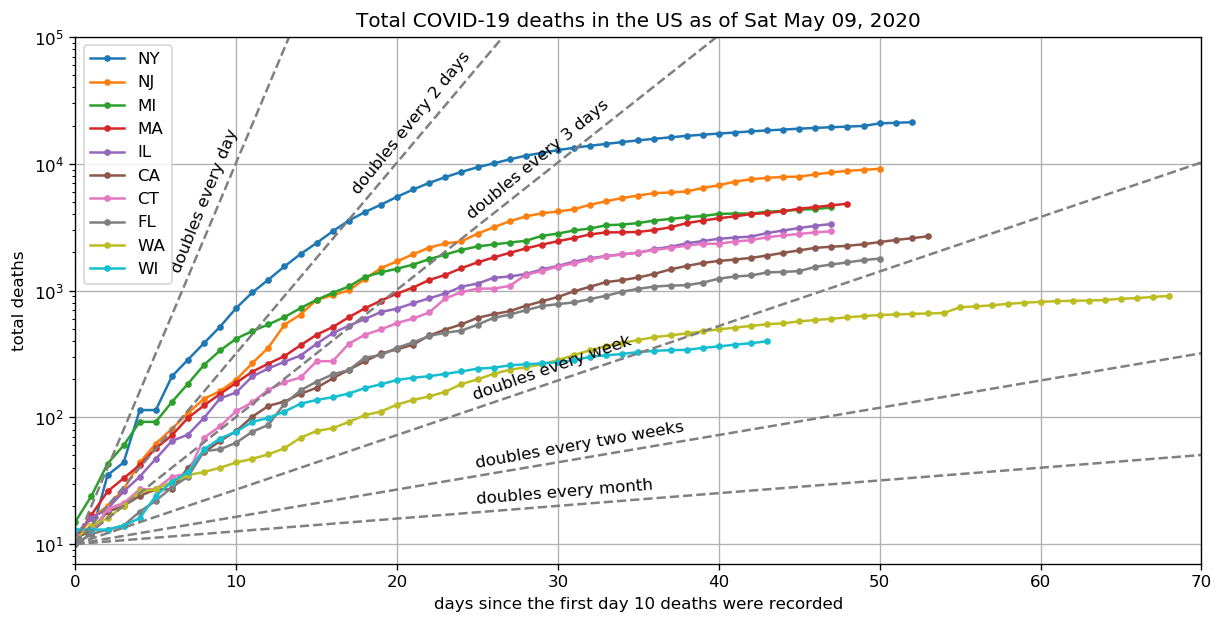

In [17]:
# function that shifts the data so everything starts from first min_deaths
def shift_data( states, min_deaths ):
    shifted_data = []
    for (c,data) in df[states].items():
        shifted_data.append( data[data >= min_deaths].reset_index(drop=True) )
    return shifted_data

# selected states
# states = deaths_sorted[:10].index
states = ['NY','NJ','MI','MA','IL','CA','CT','FL','WA','WI']
min_deaths = 10
xmax = 70

# shift data so that index corresponds to days since min_death deaths.
shifted_data = shift_data( states, min_deaths )

# merge into a single dataframe
dfx = pd.concat( shifted_data, axis=1 )

# make plot
ax = dfx.plot(title="Total COVID-19 deaths in the US as of %s" % latest_date, logy=True, figsize=(10,5), grid=True, marker='.');
ax.set_xlabel("days since the first day %g deaths were recorded" % min_deaths )
ax.set_ylabel("total deaths")
ax.set_ylim(min_deaths*.7,1e5)
ax.set_xlim(0,xmax);

# draw doubling lines (doubling every d days)
dvals = [1,2,3,7,14,30]    # values of doubling lines to draw (d)
dtxt = ["day", "2 days", "3 days", "week", "two weeks", "month"]
tloc = [7,18,25,25,25,25] # x-coordinate of text labels
for i,d in enumerate(dvals):
    tx = tloc[i]
    ty = min_deaths*(2**(tx/d))
    angle = np.arctan(ty/d * np.log(2))
    angle_screen = ax.transData.transform_angles(np.array([angle,]),np.array([[tx,ty]]),radians=True)[0]
    y = min_deaths*(2**(xmax/d))
    plt.plot([0,xmax],[min_deaths,y], '--', color='gray')
    ax.annotate("doubles every %s" % dtxt[i], xy=(tx,ty), xytext=(-5*np.sin(angle_screen),5*np.cos(angle_screen)),
                textcoords="offset points", rotation_mode='anchor', rotation=np.rad2deg(angle_screen))
plt.tight_layout(pad=0)
plt.savefig("figures/states_total_deaths_vs_time.png")

### Plot daily deaths

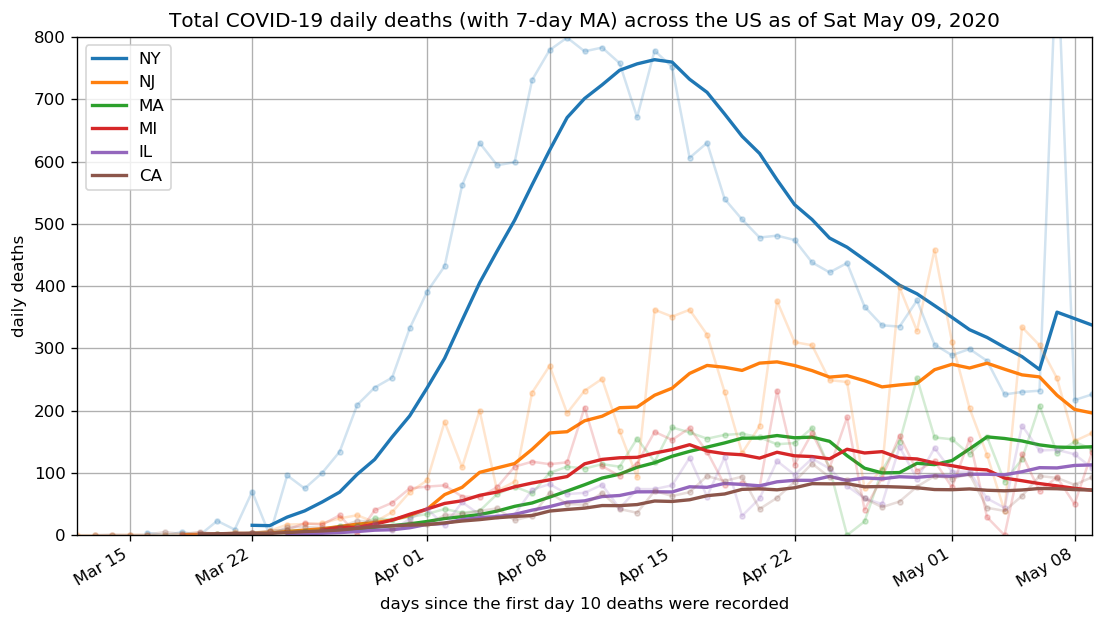

In [25]:
fig = plt.figure(figsize=(9,5))
ax = plt.gca()

# selected countries
# countries = ['US','Italy','Spain','United Kingdom','France','Iran', 'Canada', 'Korea, South', 'Japan']
states = daily_deaths_sorted[:6].index
min_deaths = 10
xmax = 75

# shift data so that index corresponds to days since min_death deaths.
shifted_data = shift_data( states, min_deaths )

for s in states:
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot( df[s].diff(), marker=".", label=None, color=color, alpha=0.2 )
    plt.plot( df[s].diff().rolling(7).mean(), marker="", label=s, color=color, linewidth=2 )

# make plot
ax.set_title("Total COVID-19 daily deaths (with 7-day MA) across the US as of %s" % latest_date)
ax.legend(loc="upper left")
ax.set_xlabel("days since the first day %g deaths were recorded" % min_deaths )
ax.set_ylabel("daily deaths")
ax.grid()
# ax.set_xlim(7,xmax)
ax.set_ylim(ymin=0,ymax=800)

fig.autofmt_xdate()
date_format = "%b %d"
ax.autoscale(enable=True, axis='x', tight=True)
ax.xaxis.set_major_formatter(DateFormatter(date_format))
    
plt.tight_layout(pad=0)
plt.savefig("figures/states_daily_deaths_vs_time.png")